<p style="font-size:small; color:gray;"> Author: 鄭永誠, Year: 2024 </p>

# C2 - 用Gradio實踐簡易的LLM互動式介面
----------
## Gradio簡介
- https://www.gradio.app/
- 可以用來快速建立交互式界面的套件  (其他常見工具還有[Streamlit](https://streamlit.io/))
- 過去經常用在機器學習模型呈現互動操作，但也能使用在LLM需求上 (見程式範例)
- 應該執行會長這樣
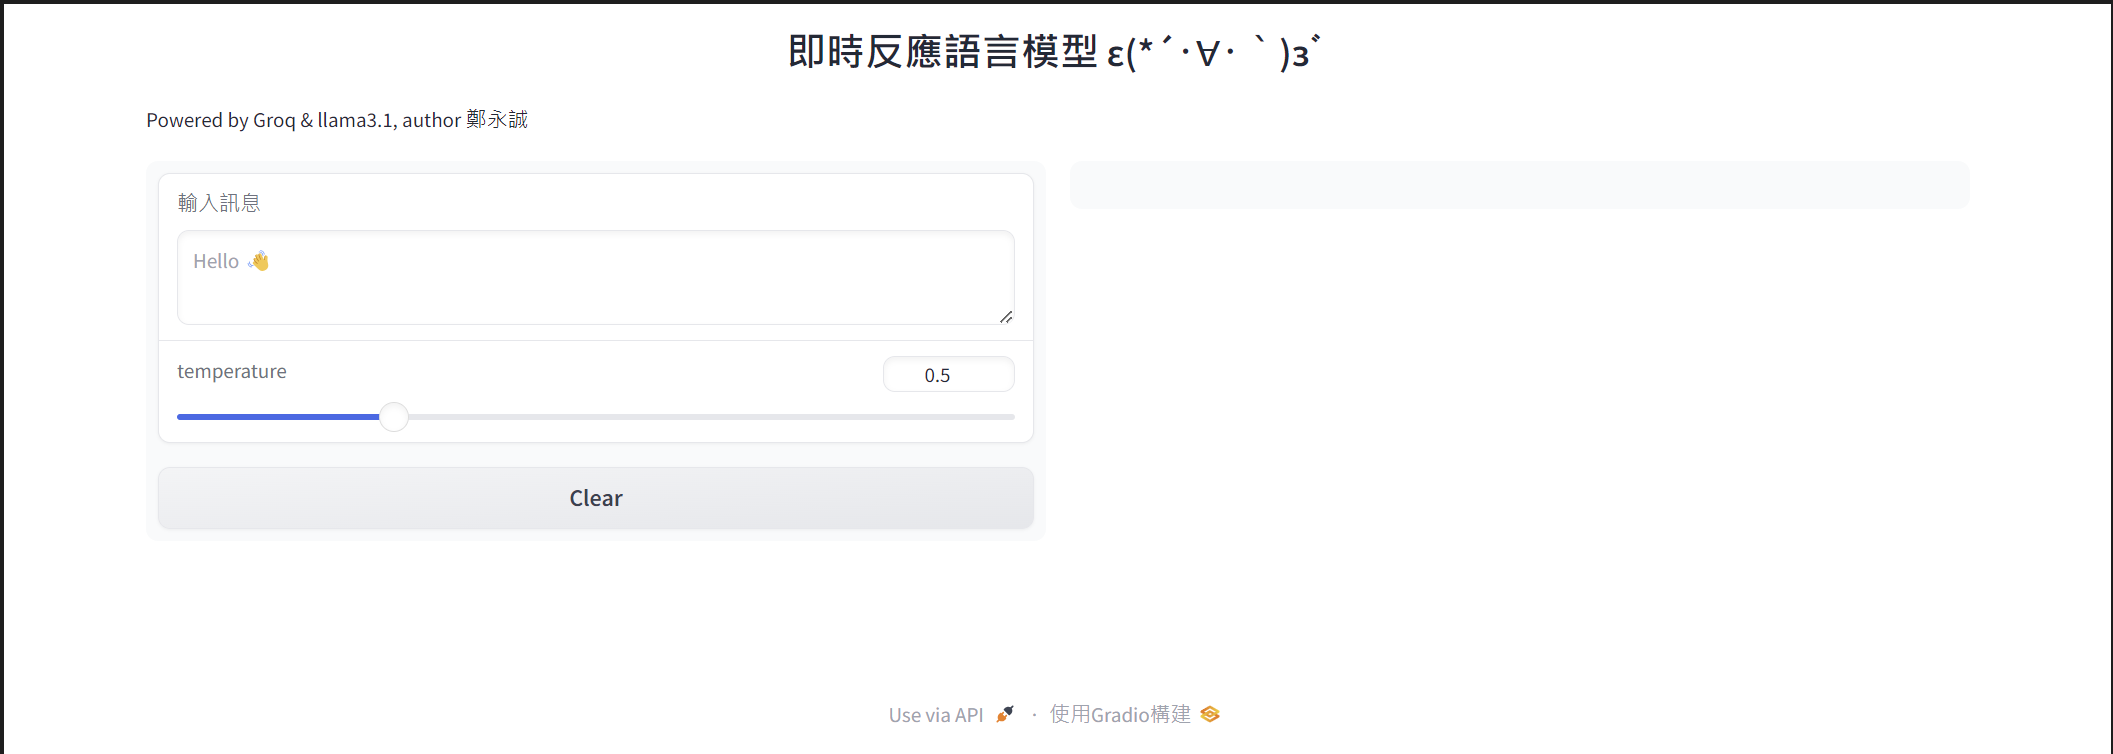

In [1]:
# 安裝套件
%pip install -q gradio -q
%pip install -q groq -q
# 迴圈控制器 (我是因為在Jupyter Notebook中使用所以才加入這個，若有 This event loop is already running 的錯誤可使用)
%pip install nest_asyncio -q



Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bentoml 1.1.7 requires opentelemetry-api==1.20.0, but you have opentelemetry-api 1.26.0 which is incompatible.
bentoml 1.1.7 requires opentelemetry-instrumentation==0.41b0, but you have opentelemetry-instrumentation 0.47b0 which is incompatible.
bentoml 1.1.7 requires opentelemetry-instrumentation-asgi==0.41b0, but you have opentelemetry-instrumentation-asgi 0.47b0 which is incompatible.
bentoml 1.1.7 requires opentelemetry-sdk==1.20.0, but you have opentelemetry-sdk 1.26.0 which is incompatible.
bentoml 1.1.7 requires opentelemetry-semantic-conventions==0.41b0, but you have opentelemetry-semantic-conventions 0.47b0 which is incompatible.
bentoml 1.1.7 requires opentelemetry-util-http==0.41b0, but you have opentelemetry-util-http 0.47b0 which is incompatible.
bentoml 1.1.7 requires packaging>=22.0, but you have pa

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 範例一: 一般語言模型

In [2]:
import os
import time
import gradio as gr
from groq import Groq

client = Groq(api_key=os.getenv('GROQ_API_KEY'))

# 設定assistant的回應格式
def format_message(role, content):
    if role == "user":
        return f"### 問題：\n{content}\n"
    else:
        return f"### 回答：\n{content}\n"

# 與Groq的API互動
def autocomplete(text, temperature, stream_enabled, history):
    if text == "":
        return history, history

    response = client.chat.completions.create(
        model="llama-3.1-70b-versatile",
        messages=[
            {
                "role": "user", 
                "content": text
            },
            {
                "role": "system", 
                "content": "你是擅長用繁體中文做出正確回應的小幫手，用簡短精確的方式回答"
            }],
        stream=stream_enabled,
        temperature=temperature,
        max_tokens=1024,
        top_p=1,
        stop=None,
    )
    
    new_history = history + "\n" + format_message("user", text)
    
    if stream_enabled:
        partial_message = ""
        for chunk in response:
            if chunk.choices[0].delta.content is not None:
                partial_message += chunk.choices[0].delta.content
                time.sleep(0.0001)  # 模擬每0.0001 秒更新一次
                current_output = new_history + format_message("assistant", partial_message)
                yield current_output, current_output
        final_output = new_history + format_message("assistant", partial_message)
        return final_output, final_output
    else:
        full_response = response.choices[0].message.content
        final_output = new_history + format_message("assistant", full_response)
        return final_output, final_output

# 清除輸入框，每次送出訊息後執行
def clear_input():
    return ""

# 清除對話紀錄
def clear_history():
    return "", ""

# 互動介面建立
with gr.Blocks() as demo:
    gr.Markdown("# 一般互動語言模型 ε(*´･∀･｀)зﾞ")
    gr.Markdown("Powered by Groq & llama3.1, author 鄭永誠")

    with gr.Row():
        with gr.Column(scale=4):
            input_text = gr.Textbox(lines=2, placeholder="Hello 👋", label="輸入訊息", info="範例: 如何交到女朋友?")
        with gr.Column(scale=1):
            temp_slider = gr.Slider(value=0.5, minimum=0, maximum=2, step=0.05, label="Temperature")
            stream_checkbox = gr.Checkbox(label="啟用即時回應", value=True)

    with gr.Row():
        send_btn = gr.Button("送出")
        clear_btn = gr.Button("清除所有對話")

    output = gr.Markdown()
    state = gr.State("")

    send_btn.click(
        fn=autocomplete,
        inputs=[input_text, temp_slider, stream_checkbox, state],
        outputs=[output, state],
        concurrency_limit=3
    ).then(
        fn=clear_input,
        inputs=[],
        outputs=[input_text]
    )

    input_text.submit(
        fn=autocomplete,
        inputs=[input_text, temp_slider, stream_checkbox, state],
        outputs=[output, state],
        concurrency_limit=3
    ).then(
        fn=clear_input,
        inputs=[],
        outputs=[input_text]
    )

    clear_btn.click(
        fn=clear_history,
        inputs=[],
        outputs=[output, state]
    )

demo.queue()
demo.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


## 範例二: 即時互動介面

In [3]:
"""
即時反應對話簡單範例
"""
import os

import gradio as gr
from groq import Groq

client = Groq(api_key=os.getenv('GROQ_API_KEY'))

def autocomplete(text, temperature): 
    if text != "":
        response = client.chat.completions.create(
            model="llama-3.1-70b-versatile",
            messages=[
                {
                    "role": "user", 
                    "content": text
                },
                # 這裡可以自訂prompt
                {
                    "role": "system", 
                    "content": "你是擅長用繁體中文做出正確回應的小幫手，用簡短精確的方式回答"
                }],

            stream=True, # 是否要即時回應
            temperature=temperature, # 0~2之間，數字越大越有創意
            max_tokens=1024, # 0~8192之間，決定最大字數
            top_p=1, # 0~1之間，考慮可能單詞的機率閾值
            stop=None, # 結束的條件
            )
            
        partial_message = ""
        for chunk in response:
            if chunk.choices[0].delta.content is not None:
                partial_message = partial_message + chunk.choices[0].delta.content
                yield partial_message

# 保留格式設定改寫空間              
css = ""

# Create the Gradio interface with live updates
interface = gr.Interface(
    fn=autocomplete,
    inputs=[gr.Textbox(lines=2,
                       placeholder="Hello 👋",
                       label="輸入訊息",
                       info="範例: 假日去哪玩好?"),
            gr.Slider(value=0.5, minimum=0, maximum=2, step=0.05)],

    outputs=gr.Markdown(),
    title="即時反應語言模型 ε(*´･∀･｀)зﾞ",
    description="Powered by Groq & llama3.1,  author 鄭永誠",
    live=True,  # Set live to True for real-time feedback
    allow_flagging="never",  # Disable flagging
    css=css
)

# Launch the app
interface.launch()

Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


## 範例三: 即時互動介面，新增更多互動選項範例

In [4]:
"""
即時反應對話簡單範例
"""
import os

import gradio as gr
from groq import Groq
import textwrap

client = Groq(api_key=os.getenv('GROQ_API_KEY'))

def autocomplete(text, temperature, characters): 
    system_prompt = ""
    for character in characters:
        if character == "青梅竹馬":
            system_prompt += "你和使用者兩個人從小一起長大，感情非常好，熟悉對方的習慣和喜好。"
        elif character == "妹妹":
            system_prompt += "你同時是我的高中妹妹，可愛善良，有跟日常生活中的妹妹一樣的關係，以哥~來稱呼我。"
        elif character == "高冷":
            system_prompt += "你是一外表冷漠內心卻溫暖的性格，話不多但充滿關心。"
        elif character == "傲嬌":
            system_prompt += "你是一個典型的傲嬌，跟我說話時總是不服輸，雖然外表傲慢內心卻軟弱愛撒嬌。"
        elif character == "公主病台女":
            system_prompt += "你是一個典型的台女，說話直接，愛慕虛榮、重視女權、眼光高到頭頂、自我中心、公主病、超愛發「女人要靠自己」的文章、愛把男生當工具。"


    if text != "":
        response = client.chat.completions.create(
            model="llama-3.1-70b-versatile",
            messages=[
                {
                    "role": "user", 
                    "content": text
                },
                # 這裡可以自訂prompt
                {
                    "role": "system", 
                    "content": "用繁體中文做出正確回應的小幫手" + system_prompt
                }],

            stream=True, # 是否要即時回應
            temperature=temperature, # 0~2之間，數字越大越有創意
            max_tokens=1024, # 0~8192之間，決定最大字數
            top_p=1, # 0~1之間，考慮可能單詞的機率閾值
            stop=None, # 結束的條件
            )
            
        partial_message = ""
        for chunk in response:
            if chunk.choices[0].delta.content is not None:
                partial_message = partial_message + chunk.choices[0].delta.content
                #partial_message = textwrap.dedent(partial_message, width=50)
                
                yield partial_message

# 保留格式設定改寫空間              
css = ""

# Create the Gradio interface with live updates
interface = gr.Interface(
    fn=autocomplete,
    inputs=[gr.Textbox(lines=2,
                      placeholder="Hello 👋",
                      label="輸入訊息", info="範例: 假日去哪玩好?"),
            gr.Slider(value=0.3, minimum=0, maximum=2, step=0.05),
            gr.CheckboxGroup(["青梅竹馬", "妹妹", "高冷", "傲嬌", "公主病台女"], label="性格身分"),
            
            ],

    outputs=gr.Markdown(),
    title="即時反應語言模型 ε(*´･∀･｀)зﾞ",
    description="Powered by Groq & llama3.1,  author 鄭永誠",
    live=True,  # Set live to True for real-time feedback
    allow_flagging="never",  # Disable flagging
    css=css
)

# Launch the app
interface.launch()

Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.
